In [1]:
import numpy as np
import random
import os
import keras_tuner as kt
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import GlobalMaxPooling2D, Activation, Dense, Conv1D, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras import optimizers
import pandas as pd
from tqdm.notebook import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy import signal


from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

from utils.augment import noise_augment, shift_augment, apply_augment
from utils.deep import preProcess, smoothLabels, oneHot, applyOneHot, evaluate_set
from utils.visualize import showMe, showHistory
from config.default import *

%load_ext autoreload
%autoreload 2


C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [44]:
root_path = 'C:/resources/EMG/'
post_fix = '_1s_cleaned' #'_1s_new' #
classes = settings['classes']


sessions_to_val = [] #'session_4'] # ['session_1','session_2','session_3','session_4']    #[] # 
subject_to_val = ['S001',  'S105']

# use session4 for validation
train_sessions = []
val_sessions = []
for subject in os.listdir(root_path):
        for session in os.listdir(os.path.join(root_path,subject)):
            if session in sessions_to_val or subject in subject_to_val:
                val_sessions.append(os.path.join(root_path,subject, session))
            else:
                train_sessions.append(os.path.join(root_path,subject, session))
        #print(f"{len(os.listdir(os.path.join(root_path,subject)))} session loaded from subject: {subject}")




train_records = {}
if len(train_sessions) > 0:
    for c in classes:
        class_data = []
        for session in train_sessions:
            data = np.load(os.path.join(session,c+post_fix+'.npy'),allow_pickle=True)
            if data.shape[0] != 0:
                class_data.append(data)
            else:
                #val_records[c] = np.random.rand(1, 4, 500)
                #print(f'WARNING! CREATING RANDOM DATA FOR {c}')
                print(f"No data available for train for class {c}")
        
        train_records[c] = np.concatenate(class_data)
    print(f"{len(train_sessions)} sessions loaded for training")
else:
    print("No train session available")

val_records = {}
for c in classes:
    class_data = []
    for session in val_sessions:
        data = np.load(os.path.join(session,c+post_fix+'.npy'),allow_pickle=True)
        if data.shape[0] != 0:
            class_data.append(data)
    if len(class_data) != 0:
        val_records[c] = np.concatenate(class_data)
    else:
        #val_records[c] = np.random.rand(1, 4, 500)
        #print(f'WARNING! CREATING RANDOM DATA FOR {c}')
        print(f"No data available for validation for class {c}")

print(f"{len(val_sessions)} sessions loaded for validation")

No data available for train for class Chew
No data available for train for class Chew
No data available for train for class Chew
No data available for train for class Smile
No data available for train for class Smile
No data available for train for class Smile
No data available for train for class Smile
No data available for train for class Smile
No data available for train for class Smile
No data available for train for class Smile
No data available for train for class Smile
50 sessions loaded for training
8 sessions loaded for validation


In [45]:
def create_labels(X):
    y = []
    for i, r in enumerate(X):
        l = np.ones(X[r].shape[0])*i
        y = y + l.tolist()
    y = np.array(y)
    return y

In [46]:
print("TRAIN SET")
for r in train_records:
    print(f'{r} -> {train_records[r].shape}')

print("VAL SET")
for r in val_records:
    print(f'{r} -> {val_records[r].shape}')

TRAIN SET
Rest -> (2088, 4, 500)
Eyebrow -> (2880, 4, 500)
Chew -> (1866, 4, 500)
Smile -> (1215, 4, 500)
VAL SET
Rest -> (201, 4, 500)
Eyebrow -> (519, 4, 500)
Chew -> (294, 4, 500)
Smile -> (285, 4, 500)


In [47]:
n_channels = train_records["Rest"].shape[1]
input_length = train_records["Rest"].shape[2]


print('Train')
train_y = create_labels(train_records)
train_X = np.concatenate((list(train_records.values())), axis=0)
print(train_X.shape)
print(train_y.shape)


print('Validation:')
val_y = create_labels(val_records)
val_X = np.concatenate((list(val_records.values())), axis=0)
print(val_X.shape)
print(val_y.shape)

Train
(8049, 4, 500)
(8049,)
Validation:
(1299, 4, 500)
(1299,)


In [48]:
train_X = np.array(train_X).reshape(-1,n_channels,input_length)
train_y = np.array(train_y)

val_X = np.array(val_X).reshape(-1,n_channels,input_length)
val_y = np.array(val_y)


train_y = applyOneHot(train_y,len(classes))
val_y = applyOneHot(val_y,len(classes))


print(train_X.shape)
print(train_y.shape)

print(val_X.shape)
print(val_y.shape)


(8049, 4, 500)
(8049, 4)
(1299, 4, 500)
(1299, 4)


In [49]:
train_X, train_y = apply_augment(train_X, train_y)
print("After augmentation")
print(train_X.shape)
print(train_y.shape)


After augmentation
(24147, 4, 500)
(24147, 4)


In [50]:
c = list(zip(train_X, train_y))
random.seed(42)
random.shuffle(c)
train_X,train_y = zip(*c)
train_X = np.array(train_X)
train_y = np.array(train_y)

In [82]:
def get_model():
    inspected_chanels= train_X.shape[1]
    input_length=     train_X.shape[2]
    l2 = 0.000001

    input_layer = keras.Input(shape = (inspected_chanels,input_length,1), name='input')

    x     = layers.AveragePooling2D(pool_size=(1,5))(input_layer) # resample


   
   
    x     = layers.Conv2D(256, kernel_size=(1,5), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.AveragePooling2D(pool_size=(1,5))(x)

    x     = layers.Conv2D(256, kernel_size=(4,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.AveragePooling2D(pool_size=(4,1))(x)

    x     = layers.Dense(500,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.Flatten()(x)

 
   
    

    x     = layers.Dense(200,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.Dropout(.1)(x)

    
    


    output = layers.Dense(len(classes), activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output)

    #model.summary()
    return model

In [95]:
model = get_model()


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                               patience=2, min_lr=1e-7,)
                              
# early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.000001)

opt = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(optimizer=opt,
          loss='categorical_crossentropy',
          metrics=['categorical_accuracy']
         )


Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 4, 500, 1)]       0         
_________________________________________________________________
average_pooling2d_48 (Averag (None, 4, 100, 1)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 4, 100, 256)       1536      
_________________________________________________________________
batch_normalization_48 (Batc (None, 4, 100, 256)       1024      
_________________________________________________________________
average_pooling2d_49 (Averag (None, 4, 20, 256)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 4, 20, 256)        262400    
_________________________________________________________________
batch_normalization_49 (Batc (None, 4, 20, 256)      

Epoch 1/30
189/189 [==============================] - 5s 27ms/step - loss: 0.7823 - categorical_accuracy: 0.7593 - val_loss: 1.4077 - val_categorical_accuracy: 0.2263
Epoch 2/30
189/189 [==============================] - 5s 25ms/step - loss: 0.5343 - categorical_accuracy: 0.8765 - val_loss: 1.0246 - val_categorical_accuracy: 0.6490
Epoch 3/30
189/189 [==============================] - 5s 24ms/step - loss: 0.4808 - categorical_accuracy: 0.9014 - val_loss: 0.6686 - val_categorical_accuracy: 0.8299
Epoch 4/30
189/189 [==============================] - 5s 25ms/step - loss: 0.4473 - categorical_accuracy: 0.9164 - val_loss: 0.5193 - val_categorical_accuracy: 0.9092
Epoch 5/30
189/189 [==============================] - 5s 24ms/step - loss: 0.4262 - categorical_accuracy: 0.9250 - val_loss: 0.5778 - val_categorical_accuracy: 0.8830
Epoch 6/30
189/189 [==============================] - 5s 25ms/step - loss: 0.4127 - categorical_accuracy: 0.9312 - val_loss: 0.4887 - val_categorical_accuracy: 0.919

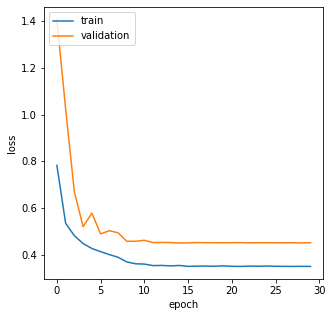

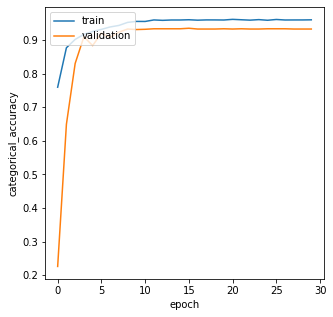

0.9345650672912598


In [96]:
##############################################
############     TRAIN MODEL     #############
##############################################

batch_size = 128
history = model.fit(train_X,
                    train_y,
                    validation_data=(val_X, val_y),
                    batch_size=batch_size,
                    epochs=30,
                    shuffle=True,
                    callbacks = [reduce_lr]
                    )

showHistory(history)      
try:    
    acc = max(history.history['val_accuracy'])
except:
    acc = max(history.history['val_categorical_accuracy'])

print(acc)

In [ ]:
evaluate_set(model, train_sessions, classes, post_fix, input_length=input_length, log = False)

In [97]:
evaluate_set(model, val_sessions, classes,  post_fix, input_length=input_length, log = False)

  0%|          | 0/8 [00:00<?, ?it/s]

Global accuracy: 92.0%
         Accuracy
Subject          
S001        96.75
S105        87.25
